In [58]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [59]:
df = pd.read_csv("../data/raw/bank/bank-full.csv", sep=";")

In [60]:
df['treatment'] = df['loan'].map({'yes': 1, 'no': 0}) 

In [61]:
X = df.drop(columns=['y', 'loan', 'treatment'])  # drop target and treatment
y = df['treatment']

In [62]:
X = pd.get_dummies(X, drop_first=True)

In [63]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [64]:
logreg = LogisticRegression(solver='saga', max_iter=1000)
logreg.fit(X_scaled, y)
df['propensity_score'] = logreg.predict_proba(X_scaled)[:, 1]

In [65]:
def match_sample(df, caliper=0.05):
    treated = df[df['treatment'] == 1]
    control = df[df['treatment'] == 0]
    matched_control = []

    for _, row in treated.iterrows():
        potential_matches = control[abs(control['propensity_score'] - row['propensity_score']) <= caliper]
        if not potential_matches.empty:
            match = potential_matches.sample(random_state=42)
            matched_control.append(match)
            control = control.drop(match.index)

    matched_control = pd.concat(matched_control)
    return pd.concat([treated, matched_control])

In [66]:
matched_df_loan = match_sample(df.copy())
matched_df_loan['y_numeric'] = matched_df_loan['y'].map({'yes': 1, 'no': 0})

att_loan = matched_df_loan[matched_df_loan['treatment'] == 1]['y_numeric'].mean() - \
           matched_df_loan[matched_df_loan['treatment'] == 0]['y_numeric'].mean()

print(f"ATT for Loan Treatment: {att_loan:.4f}")

ATT for Loan Treatment: -0.0240


/var/folders/l4/t9jrg3810fj7mltqzxyw19sh0000gn/T/ipykernel_29056/748964909.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['treatment'] == 1]['propensity_score'], label='Treated', shade=True)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/l4/t9jrg3810fj7mltqzxyw19sh0000gn/T/ipykernel_29056/748964909.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['treatment'] == 0]['propensity_score'], label='Control', shade=True)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarni

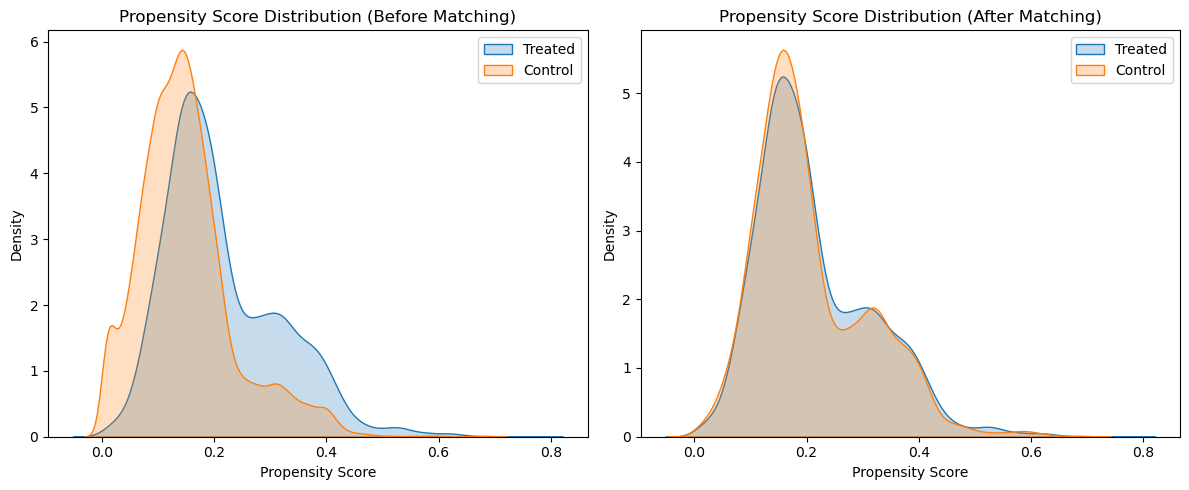

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))

# Before Matching
plt.subplot(1, 2, 1)
sns.kdeplot(df[df['treatment'] == 1]['propensity_score'], label='Treated', shade=True)
sns.kdeplot(df[df['treatment'] == 0]['propensity_score'], label='Control', shade=True)
plt.title('Propensity Score Distribution (Before Matching)')
plt.xlabel('Propensity Score')
plt.legend()

# After Matching
plt.subplot(1, 2, 2)
sns.kdeplot(matched_df_loan[matched_df_loan['treatment'] == 1]['propensity_score'], label='Treated', shade=True)
sns.kdeplot(matched_df_loan[matched_df_loan['treatment'] == 0]['propensity_score'], label='Control', shade=True)
plt.title('Propensity Score Distribution (After Matching)')
plt.xlabel('Propensity Score')
plt.legend()

plt.tight_layout()
plt.show()


In [68]:
from scipy.stats import ttest_ind

# Ensure outcome is numeric
matched_df_loan['y_numeric'] = matched_df_loan['y'].map({'yes': 1, 'no': 0})

# Split treated and control groups
treated_outcomes = matched_df_loan[matched_df_loan['treatment'] == 1]['y_numeric']
control_outcomes = matched_df_loan[matched_df_loan['treatment'] == 0]['y_numeric']

# Perform independent t-test
t_stat, p_val = ttest_ind(treated_outcomes, control_outcomes)

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.4f}")


T-statistic: -5.3556
P-value: 0.0000


In [69]:
matched_df_loan.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y', 'treatment', 'propensity_score',
       'y_numeric'],
      dtype='object')

In [73]:
matched_df_loan[['treatment','propensity_score']].sample(5,random_state=42)

,treatment,propensity_score
18003,0,0.365144
25682,0,0.139591
13507,1,0.216784
16578,1,0.333932
1350,1,0.167584
